![](https://images.pexels.com/photos/3701276/pexels-photo-3701276.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# MARG Digital Compasses

Kevin J. Walchko, Phd

3 Jan 2021

---

## References

- [Madgwick, *An efficient orientation filter for inertial and inertial/magnetic sensor arrays*](madgwick.pdf)

## Quaternion Basics

Here we will use Hamiltonian (right-handed) quaternions throughout this work. The notation on the quaternion frames is $^{From}_{To}q$.

$$
^A_Cq = {}^B_Cq \otimes {}^A_Bq \\
^A_Bq = \begin{bmatrix} q_1 & q_2 & q_3 & q_4 \end{bmatrix} \\
^A_Bq^* = {}^B_Aq = \begin{bmatrix} q_1 & -q_2 & -q_3 & -q_4 \end{bmatrix} \\
^Bv = {}^A_Bq \otimes {}^Av \otimes {}^A_Bq^* 
$$

# Filter Equations

Madgwick did a great job designing this filter, but I find his paper hard to follow, especially with several typos in the mathematics. So I tried to boil it down to the useful equations.

![](marg.png)

## Definitions

| Symbol | Definition |
|---|:---|
| $S$ | Sensor Frame |
| $E$ | Earth Frame |
| $||x||$ | Norm of $x$ |
| $f_{g,b}$ | Objective function|
| $J_{g,b}$ | Jacobian of the objective funtion based on the gravity and magnetic field references |
| $\nabla f$ | Gradient of the cost function which is composed of Jacobian and the objective function: $J^T_g f_g + J^T_{g,b} f_{g,b}$ |
| $\omega_t$ | Raw gyro values |
| $\omega_c$ | Converted gyro values free of biases |
| $a_t$ | accelerometer values |
| $m_t$ | magnetometer values |
| $\zeta$ | Gain for drift estimation |
| $\beta$ | Gain for filter or learning rate based on gradient feedback |
| $^S_Eq_t$ | Orientation at current time step |
| $^Eb_t$ | Magnetic field reference at current time step which is derived from $m_t$ |
| $^Eg$ | Gravitational reference at current time step |


## Initialize

$$
^S_Eq_t = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \\
^{S}\omega_{b,t} = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T
$$

## Loop

1. Get accelerometer ($^Sa_t$), magnetometer ($^Sm_t$), and gyroscope ($^S\omega_t$) from the IMU
1. Normalize $^Sa_t$ and $^Sm_t$
1. Make sure the gyro is converted, if necessary, to rads/sec and not deg/sec
1. Calculate time step $\Delta t$ from last sample time
1. Calculate the reference magnetic field based on the magnetometer
    1. Find alignment [45]: $^{E}\hat h_t = ^{S}_{E}\hat q_{est,t-1} \otimes ^S \hat m_t \otimes ^{S}_{E}\hat q^{*}_{est,t-1}$
    1. Create quaternion representation [46]: $^{E}\hat b_t = \begin{bmatrix} 0 & \sqrt{h^2_x + h^2_y} & 0 & h_z \end{bmatrix}$
1. Calculate the gradient $\nabla f$ and normalize to get $\frac{\nabla f}{|| \nabla f||}$, the formulation of $\Delta f$ is discussed below in the gradient section
1. Calculate the gyro bias:
    1. Estimate the error [47]: $^{S}\omega_{\epsilon,t} = 2^S_E\hat q^{*}_{est,t-1} \otimes \frac{\nabla f}{|| \nabla f||}$
    1. Integrate (discrete time) to get the current bias estimate [48]: $^{S}\omega_{b,t} = \zeta \sum ^{S}\omega_{\epsilon,t} \Delta t$
        1. $\zeta$ is the drift rate (rad/s/s) $\sqrt{\frac{3}{4}} \dot \omega_{\zeta}$
    1. Correct the raw gyro values [49]: $^{S}\omega_{c,t} = ^{S}\omega_{t} - ^{S}\omega_{b,t}$
1. Update orientation based on corrected gyros [12]: $^{S}_{E}\dot q_{\omega,t} = \frac{1}{2} ^{S}_{E}\hat q_{est,t-1} \otimes ^{S}\omega_{c,t}$
1. Correct the orientation rate using the estimated error [43]: $^{S}_{E}\dot q_{est,t} = ^{S}_{E}\dot q_{\omega,t} - \beta \frac{\nabla f}{|| \nabla f||}$
    1. Now $\beta$ is based on the error (rad/s) of  the gyro, you can use: $\sqrt{\frac{3}{4}} \omega_{\beta}$
1. Integrate (discrete time) the orientation rate to get the updated orientation [42]: $^{S}_{E}\hat q_{est,t} = ^{S}_{E}\hat q_{est,t-1} + ^{S}_{E}\dot q_{est,t} \Delta t$

## Gradient

For the MARG, the gradient uses [21] and [22]. By substituting in values for gravity ($^Eg = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$) and the magnetic field reference, the equation simplify down to [25],[26],[29],[30]:

$$
\nabla f = J^T_g f_g + J^T_{g,b} f_{g,b} \\
f_g = \begin{bmatrix}
    2(q_2q_4-q_1q_3)-a_x \\
    2(q_1q_2+q_3q_4)-a_y \\
    2(0.5-q_2^2-q_3^2)-a_z
\end{bmatrix} \\
J_g = \begin{bmatrix}
    -2q_3 &  2q_4 & -2q_1 & 2q_2 \\
     2q_2 &  2q_1 &  2q_4 & 2q_3 \\
        0 & -4q_2 & -4q_3 &    0
\end{bmatrix} \\
f_{g,b} = \begin{bmatrix}
    2b_x(0.5-q_3^2-q_4^2)+2b_z(q_2q_4-q_1q_3)-m_x \\
      2b_x(q_2q_3-q_1q_4)+2b_z(q_1q_2+q_3q_4)-m_y \\
     2b_x(q_1q_3+q_2q_4)+2b_z(0.5-q_2^2-q3^2)-m_z
\end{bmatrix} \\
J_{g,b} = \begin{bmatrix}
            -2b_zq_3 &            2b_zq_4 & -4b_xq_3-2b_zq_1 & -4b_xq_4+2b_zq_2 \\
    -2b_xq_4+2b_zq_2 &    2b_xq_3+2b_zq_1 &  2b_xq_2+2b_zq_4 & -2b_xq_1+2b_zq_3 \\
             2b_xq_3 &    2b_xq_4-4b_zq_2 &  2b_xq_1-4b_zq_3 &          2b_xq_2
\end{bmatrix} \\
$$

where $b = b_t$, $a = a_t$, $m = m_t$, and $q = ^{S}_{E}\hat q_{est,t-1}$.

# Get Data

In [1]:
import numpy as np # matrix manipulations

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Json, Pickle

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

the-collector: 0.8.7


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [3]:
!ls -lh

total 23M
-rw-rw-r-- 1 kevin kevin  78K Oct 18 11:26 ahrs-2.ipynb
-rw-rw-r-- 1 kevin kevin 204K Oct 16 07:07 attitude-heading-reference-system.ipynb
-rwxrwxr-x 1 kevin kevin  11M May 10 15:48 imu-1-2.json
-rwxrwxr-x 1 kevin kevin  11M Jul  5 10:18 imu-1-2.json-gz.bag
-rw-rw-r-- 1 kevin kevin 140K May 10 15:48 imu-rpi.2019-05-04-20:47:18.445193.pickle.bag
-rw-rw-r-- 1 kevin kevin  71K Oct 18 10:25 marg.png
-rw-rw-r-- 1 kevin kevin 554K May 10 15:48 sensor_data.mp4


In [4]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

# bag = BagIt(Pickle)
# fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
# data = bag.read(fname)

bag = the_collector.BagIt(Json)
bag.packer.compress(True)
fname = "imu-1-2.json-gz.bag"
data = bag.read(fname)
# print(f">> Bagit keys: {data.keys()}")
bag_info(data)

>> Reading[json-gz]: imu-1-2.json-gz.bag
Bag keys:
--------------------------------------------------
        gyro: 585    
      camera: 585    
       accel: 585    
         mag: 585    
     b64keys: 1      


In [5]:
# data is an array of IMU messages
def get(bag, key):
    data = {"x":[], "y":[],"z":[],"ts":[]}
    for (x,y,z),ts in bag[key]:
        data["x"].append(x)
        data["y"].append(y)
        data["z"].append(z)
        data["ts"].append(ts)
    return data

adf = pd.DataFrame(get(data, "accel"))
gdf = pd.DataFrame(get(data, "gyro"))
mdf = pd.DataFrame(get(data, "mag"))

# Run AHRS

Now the AHRS uses all of the sensors in the IMU. The code is shown below:

In [6]:
# this seems wrong, give different answer than Wikipedia
# also, his quaternions are different [c(t/2), -r*s(t/2), ...], why negative?
from math import atan2, asin, pi
def euler(q):
    q1,q2,q3,q4 = q
    r2d = 180/pi
    y = atan2(2*q2*q3-2*q1*q4,2*q1**2+2*q2**2-1) * r2d
    p = -asin(2*q2*q4+2*q1*q3) * r2d
    r = atan2(2*q3*q4-2*q1*q2,2*q1**2+2*q4**2-1) * r2d

    # adafruit
#     q0,q1,q2,q3 = q
#     r = atan2(q0 * q1 + q2 * q3, 0.5 - q1 * q1 - q2 * q2) * r2d
#     p = asin(-2.0 * (q1 * q3 - q0 * q2)) * r2d
#     y = atan2(q1 * q2 + q0 * q3, 0.5 - q2 * q2 - q3 * q3) * r2d
    return (r,p,y,)

# Doff

Ground truth:

- CW ~390, greater than 1 full rotation
- CCW ~410, back pass the starting point some
- Back to start + ~30, ended CW more than the starting point

In [7]:
import squaternion    
# from numpy import sqrt
from math import sqrt
from math import pi
from numpy.linalg import norm

In [8]:
wb = np.array([0,0,0])
wes = []

def comp(q, del_f, dt):
    global wb
    zeta = sqrt(3/4)*0.2*pi/180 # gyro drift: rad/s/s
    qwe = 2.0*q.conjugate*del_f         # 47
    qwe = qwe.normalize
    wb = wb + zeta*np.array(qwe[1:])*dt # 48
    return wb

def calc_b(m,q):
    # wiki: v' = q.v.q*
    h = q*Quaternion(0,m[0],m[1],m[2])*q.conjugate # 45
    return (sqrt(h.x**2+h.y**2),0,h.z)             # 46

def grad(q,a,m,b):
    ax,ay,az = a
    mx,my,mz = m
    bx,by,bz = b
    q1,q2,q3,q4 = q
    
    fg = np.array([
        [2*(q2*q4-q1*q3)-ax],
        [2*(q1*q2+q3*q4)-ay],
        [2*(0.5-q2**2-q3**2)-az]
    ]) # 25
    Jg = np.array([
        [-2*q3,  2*q4, -2*q1, 2*q2],
        [ 2*q2,  2*q1,  2*q4, 2*q3],
        [    0, -4*q2, -4*q3,    0]
    ]) # 26
    
    fb = np.array([
        [2*bx*(0.5-q3**2-q4**2)+2*bz*(q2*q4-q1*q3)-mx],
        [    2*bx*(q2*q3-q1*q4)+2*bz*(q1*q2+q3*q4)-my],
        [2*bx*(q1*q3+q2*q4)+2*bz*(0.5-q2**2-q3**2)-mz]
    ]) # 29
    Jb = np.array([
        [        -2*bz*q3,         2*bz*q4, -4*bx*q3-2*bz*q1, -4*bx*q4+2*bz*q2],
        [-2*bx*q4+2*bz*q2,    2*bx*q3+2*bz*q1,  2*bx*q2+2*bz*q4, -2*bx*q1+2*bz*q3],
        [         2*bx*q3, 2*bx*q4-4*bz*q2,  2*bx*q1-4*bz*q3,          2*bx*q2]
    ]) # 30
    
#     qq = (Jg.T @ fg + Jb.T @ fb).T[0]
    aa = (Jg.T @ fg).T[0]
    bb = (Jb.T @ fb).T[0]
    qq = Quaternion(*aa).normalize + Quaternion(*bb).normalize 
    return qq.normalize

def loop_once(q,a,m,g,B,dt, wcomp=True):
    a = a/norm(a)
    m = m/norm(m)
    w = g * np.pi/180
    
    b = calc_b(m,q)         # calc Earth magnetic field reference
    del_f = grad(q,a,m,b)   # gradient decent algorithm
#     del_f = del_f.normalize # norm
    
    if wcomp:
        wb = comp(q,del_f,dt)         # calculate bias
        wes.append(wb)                # save for plotting
        wc = w - wb                   # 49
        qdw = 0.5*q*Quaternion(0,*wc) # update
    else:
        qdw = 0.5*q*Quaternion(0,*w) # NO GYRO COMP!!!!
    
    qdot = qdw-B*del_f # filter
    q = q + qdot*dt    # integrate
    return q.normalize

In [12]:
# get some iterators for each DataFrame
accel = adf.itertuples(index=False)
gyro = gdf.itertuples(index=False)
mag = mdf.itertuples(index=False)

# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

last = adf["ts"][0]-0.1 # starting time stamp
tt = 0               # Test time
q = Quaternion()
B = sqrt(3/4)*5*pi/180  # gyro measurement error rad/s
for aa, mm, gg in zip(accel, mag, gyro):
    # data stored as ((x,y,z), timestamp), break appart
    a = np.array(aa[:3])
    m = np.array(mm[:3])
    g = np.array(gg[:3])
    
    dt = aa[3] - last # calculate time step
    
    q = loop_once(q,a,m,g,B,dt,True)  # get orientation
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    # keep track of test time
    tt += dt
    e["tt"].append(tt)
    
    last = aa[3]  # save previous time stamp

euler2 = pd.DataFrame(e)

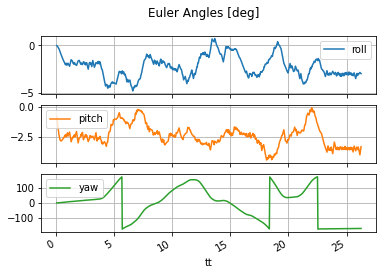

In [13]:
euler2.plot(x="tt", subplots=True, grid=True, title="Euler Angles [deg]");

[ 0.00128937  0.01437397 -0.03148051]


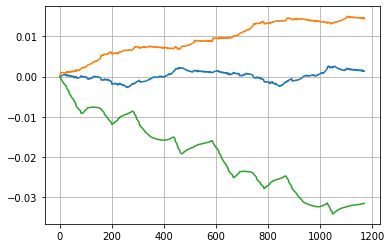

In [14]:
print(wb)
plt.plot(wes)
plt.grid(True);